# Voice Activity Detection

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/vad](https://github.com/huseinzol05/malaya-speech/tree/master/example/vad).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on MUSAN and selected Youtube videos gathered at https://github.com/huseinzol05/malaya-speech/tree/master/data/noise

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.load('speech/7021-79759-0004.flac')
len(y), sr

(391520, 16000)

### Load WebRTC

```python
def webrtc(
    aggressiveness: int = 3,
    sample_rate: int = 16000,
    minimum_amplitude: int = 100,
):
    """
    Load WebRTC VAD model.

    Parameters
    ----------
    aggressiveness: int, optional (default=3)
        an integer between 0 and 3.
        0 is the least aggressive about filtering out non-speech, 3 is the most aggressive.
    sample_rate: int, optional (default=16000)
        sample rate for samples.
    minimum_amplitude: int, optional (default=100)
        abs(minimum_amplitude) to assume a sample is a voice activity. Else, automatically False.

    Returns
    -------
    result : malaya_speech.model.webrtc.WEBRTC class
    """
```

WebRTC developed by Google, reportedly one of the best available, being fast, modern and free. Read more about pywebrtc at https://github.com/wiseman/py-webrtcvad.

**For WebRTC, we need to pass integer signal**.

In [3]:
y_int = malaya_speech.astype.float_to_int(y)
vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y_int), 0.2)))

### List available deep model

In [4]:
malaya_speech.vad.available_model()

,Size (MB),Quantized Size (MB),Accuracy
vggvox-v1,70.8,17.70,0.9500
vggvox-v2,31.1,7.92,0.9594
speakernet,20.3,5.18,0.9000


### Load deep model

Deep model trained on different noises, augmented noises, procedural noises, overlapped noises and actual voices.

```python
def deep_model(model: str = 'vggvox-v2', quantized: bool = False, **kwargs):
    """
    Load VAD model.

    Parameters
    ----------
    model : str, optional (default='vggvox-v2')
        Model architecture supported. Allowed values:

        * ``'vggvox-v1'`` - finetuned VGGVox V1.
        * ``'vggvox-v2'`` - finetuned VGGVox V2.
    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model. 
        Quantized model not necessary faster, totally depends on the machine.

    Returns
    -------
    result : malaya_speech.supervised.classification.load function
    """
```

In [5]:
model_v1 = malaya_speech.vad.deep_model(model = 'vggvox-v1')
model_v2 = malaya_speech.vad.deep_model(model = 'vggvox-v2')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### How to detect Voice Activity

In order to use available Malaya-Speech VAD models, we need to split our audio sample into really small chunks. 

For Google WebRTC, we need to split by every 30 ms. For deep learning, we trained on 30 ms, 90 ms and random length less than 300 ms.

To split an audio sample by giving time split, use, [malaya_speech.utils.generator.frames](https://github.com/huseinzol05/malaya-speech/blob/master/malaya_speech/utils/generator.py#L7)

```python
def frames(
    audio,
    frame_duration_ms: int = 30,
    sample_rate: int = 16000,
    append_ending_trail: bool = True,
):
    """
    Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and the sample rate.

    Parameters
    ----------

    audio: np.array / list
    frame_duration_ms: int, optional (default=30)
    sample_rate: int, optional (default=16000)
    append_ending_trail: bool, optional (default=True)
        if True, will append last trail and this last trail might not same length as `frame_duration_ms`.

    Returns
    -------
    result: List[malaya_speech.model.frame.FRAME]
    """
```

In [6]:
%%time

frames_int = list(malaya_speech.utils.generator.frames(y_int, 30, sr))
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

CPU times: user 88.5 ms, sys: 1 ms, total: 89.5 ms
Wall time: 89.7 ms


In [7]:
%%time

frames_webrtc = [(frame, vad(frame)) for frame in frames_int]

CPU times: user 22.2 ms, sys: 1.1 ms, total: 23.3 ms
Wall time: 22.6 ms


In [8]:
%%time

frames_deep_v1 = [(frame, model_v1(frame)) for frame in frames]

CPU times: user 1min 20s, sys: 10.3 s, total: 1min 30s
Wall time: 28.5 s


In [9]:
%%time

frames_deep_v2 = [(frame, model_v2(frame)) for frame in frames]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 36.1 s, sys: 10.1 s, total: 46.1 s
Wall time: 11.6 s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=320
  n_fft, y.shape[-1]


Took 45 seconds.

**To speedup, you can do pipeline batching to utilize parallel processing or use GPU or both**.

#### Batching pipeline

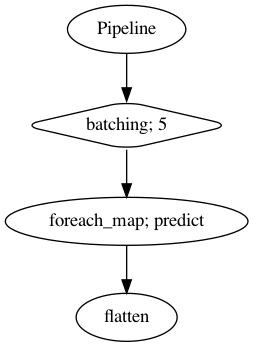

In [10]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(model_v2.predict)
    .flatten()
)
p.visualize()

In [11]:
%%time

result = p.emit(frames)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 28.6 s, sys: 4.93 s, total: 33.6 s
Wall time: 7.43 s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=320
  n_fft, y.shape[-1]


dict_keys(['batching', 'predict', 'flatten'])

Only took 30.9 seconds. We saved 16 seconds.

In [12]:
frames_deep_v2_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

In [13]:
frames_deep_v2 == frames_deep_v2_batch

True

#### get probability

Deep learning model able to calculate probability, simply use `model.predict_proba`, and make sure the input is an array or a list,

In [14]:
%%time

probs = [(frame, model_v2.predict_proba([frame])) for frame in frames]
probs[:5]

CPU times: user 36.8 s, sys: 9.74 s, total: 46.6 s
Wall time: 11.8 s


[(<malaya_speech.model.frame.Frame at 0x149e64810>,
  array([[0.72036594, 0.27963406]], dtype=float32)),
 (<malaya_speech.model.frame.Frame at 0x149e64850>,
  array([[0.7309946, 0.2690054]], dtype=float32)),
 (<malaya_speech.model.frame.Frame at 0x149e64890>,
  array([[0.7310585 , 0.26894152]], dtype=float32)),
 (<malaya_speech.model.frame.Frame at 0x149e648d0>,
  array([[0.73105365, 0.26894635]], dtype=float32)),
 (<malaya_speech.model.frame.Frame at 0x149e64910>,
  array([[0.73105854, 0.2689415 ]], dtype=float32))]

### VAD Visualization

We can visualize our audio sample to annotate which parts are active speech or not.

In [15]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

<Figure size 1500x300 with 1 Axes>

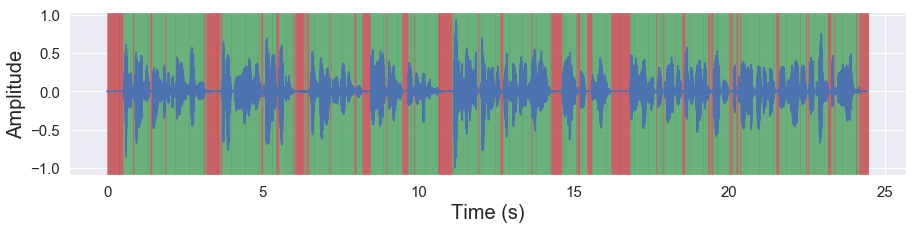

In [16]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v1, sr)

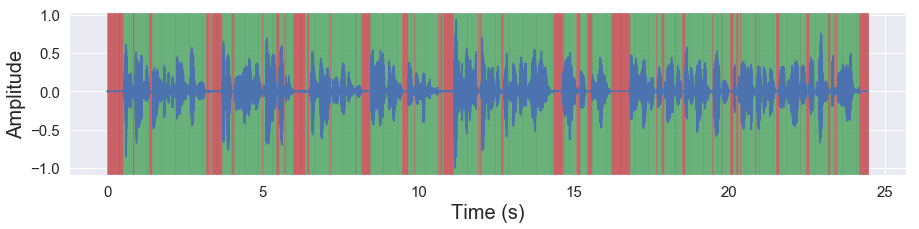

In [17]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v2, sr)

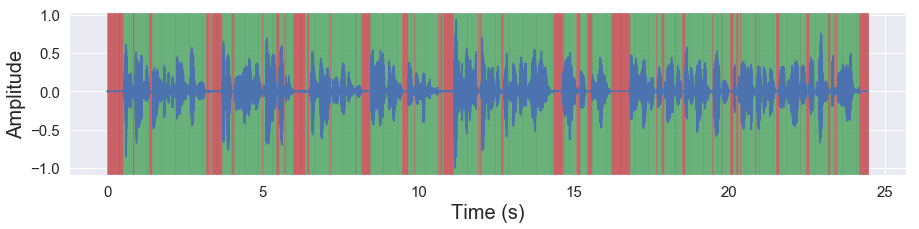

In [18]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v2_batch, sr)

### Groupby VAD

To group small samples into larger samples, use `malaya_speech.utils.group.group_frames`,

```python
def group_frames(frames):
    """
    Group multiple frames based on label.

    Parameters
    ----------
    frames: List[Tuple[Frame, label]]

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [19]:
grouped_vad = malaya_speech.utils.group.group_frames(frames_webrtc)
grouped_deep = malaya_speech.utils.group.group_frames(frames_deep_v2)

In [20]:
len(frames), len(grouped_vad), len(grouped_deep)

(816, 52, 89)

### Harder example

In the real world, not all samples recorded in clean cut studio, full with background noises, music and etc. So those are not the real voice activities. Lets take noise sound,

In [21]:
y, sr = malaya_speech.load('speech/noise/n98.wav')
len(y), sr

(64000, 16000)

In [22]:
%%time

y_int = malaya_speech.astype.float_to_int(y)
frames_int = list(malaya_speech.utils.generator.frames(y_int, 30, sr))

CPU times: user 1.1 ms, sys: 728 µs, total: 1.83 ms
Wall time: 1.16 ms


In [23]:
%%time

vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y_int), 0.2)))
frames_webrtc = [(frame, vad(frame)) for frame in frames_int]

CPU times: user 4.29 ms, sys: 1.05 ms, total: 5.34 ms
Wall time: 4.18 ms


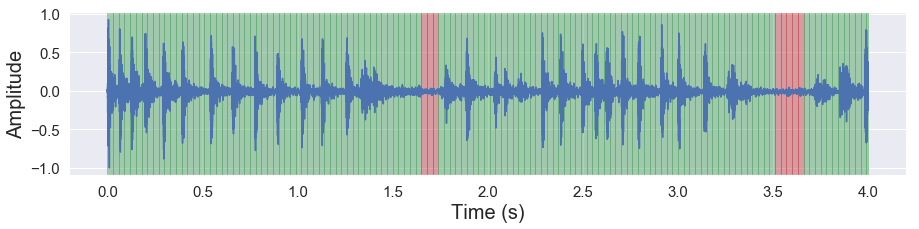

In [24]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

In [25]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))
result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 4.78 s, sys: 863 ms, total: 5.64 s
Wall time: 1.06 s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=160
  n_fft, y.shape[-1]


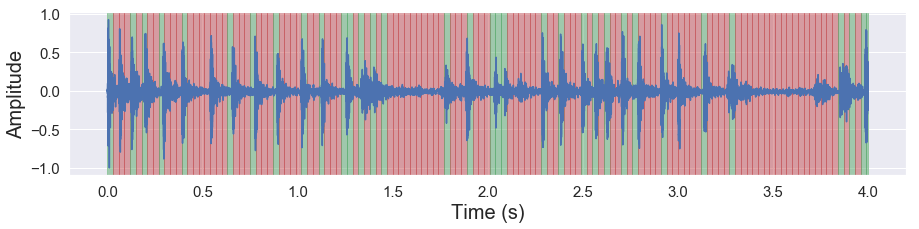

In [26]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

In [27]:
%%time

frames_deep_v1 = [(frame, model_v1(frame)) for frame in frames]

CPU times: user 13.6 s, sys: 1.68 s, total: 15.2 s
Wall time: 4.98 s


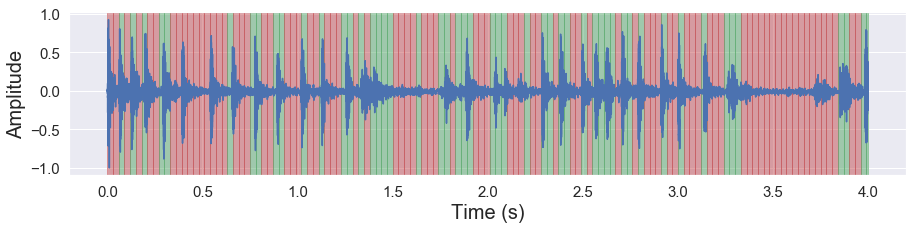

In [28]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v1, sr)

As you can see, the deep model able to know this sample mostly noises!

In [29]:
y, sr = malaya_speech.load('speech/podcast/2x5%20Ep%2010.wav')
y = y[: sr * 10]
len(y), sr

(160000, 16000)

In [30]:
y_int = malaya_speech.utils.astype.float_to_int(y)

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))
frames_int = list(malaya_speech.utils.generator.frames(y_int, 30, sr))

In [31]:
%%time

vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y_int), 0.2)))
frames_webrtc = [(frame, vad(frame)) for frame in frames_int]

CPU times: user 8.98 ms, sys: 1.21 ms, total: 10.2 ms
Wall time: 8.99 ms


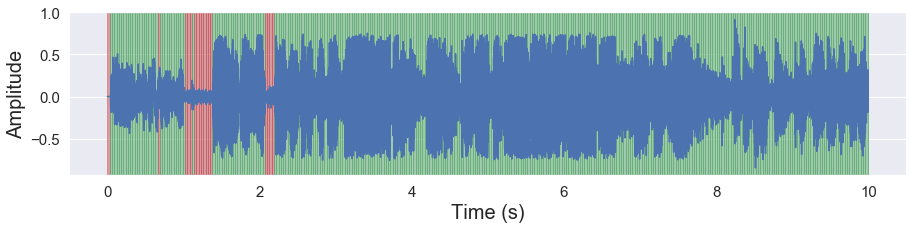

In [32]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

### Groupby based on time threshold

Group multiple frames based on label and threshold to stop.

```python
def group_frames_threshold(frames, threshold_to_stop: float = 0.3):
    """
    Group multiple frames based on label and threshold to stop.

    Parameters
    ----------
    frames: List[Tuple[Frame, label]]
    threshold_to_stop: float, optional (default = 0.3)
        If `threshold_to_stop` is 0.3, means that, length same label samples must at least 0.3 second.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [33]:
%%time

result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

CPU times: user 11.6 s, sys: 2.11 s, total: 13.8 s
Wall time: 2.89 s


In [34]:
grouped_deep = malaya_speech.utils.group.group_frames(frames_deep_batch)
grouped_deep_threshold = malaya_speech.utils.group.group_frames_threshold(grouped_deep, 0.05)

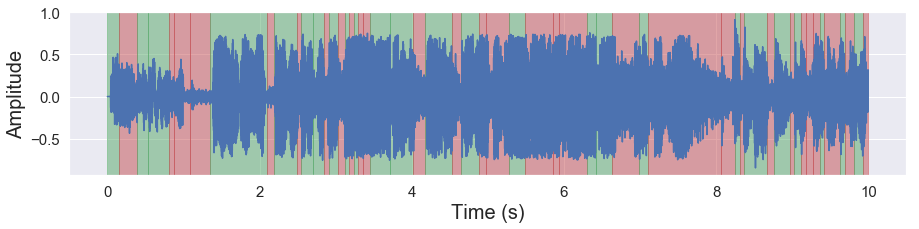

In [35]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_deep_threshold, sr)

In [36]:
%%time

frames_deep_v1 = [(frame, model_v1(frame)) for frame in frames]

CPU times: user 34.3 s, sys: 4.37 s, total: 38.6 s
Wall time: 12.5 s


In [37]:
grouped_deep = malaya_speech.utils.group.group_frames(frames_deep_batch)
grouped_deep_threshold = malaya_speech.utils.group.group_frames_threshold(grouped_deep, 0.05)

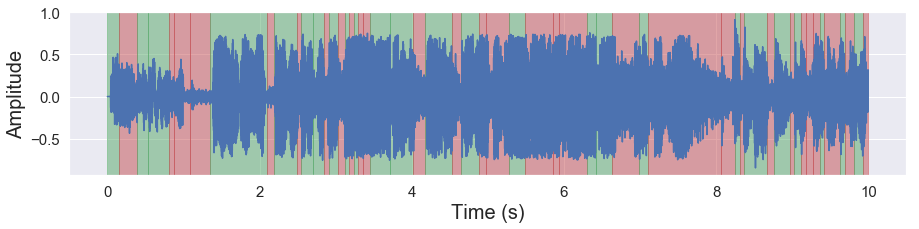

In [38]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_deep_threshold, sr)

### Load Quantized deep model

To load 8-bit quantized model, simply pass `quantized = True`, default is `False`.

We can expect slightly accuracy drop from quantized model, and not necessary faster than normal 32-bit float model, totally depends on machine.

In [39]:
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [40]:
%%time

frames_deep_v2 = [(frame, model_v2(frame)) for frame in frames]

CPU times: user 15 s, sys: 4.55 s, total: 19.6 s
Wall time: 4.57 s


In [41]:
%%time

frames_deep_v2_quantized = [(frame, quantized_model(frame)) for frame in frames]

CPU times: user 17 s, sys: 5.39 s, total: 22.3 s
Wall time: 5.42 s


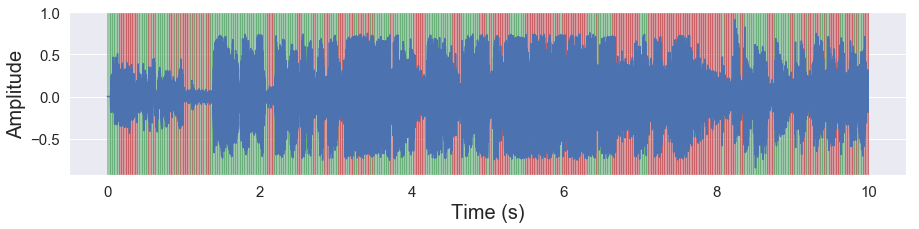

In [42]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v2, sr)

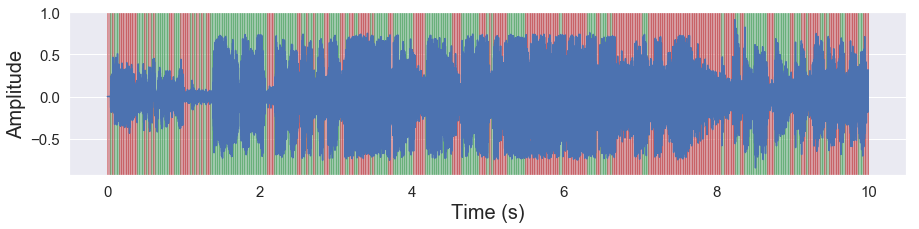

In [43]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v2_quantized, sr)